# Select ML Algorithm
Determine which algorithm works best for this dataset, validate the algorithm

In [1]:
%matplotlib inline
from copy import deepcopy
from glob import glob
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import cross_validate, cross_val_predict, RepeatedKFold, GridSearchCV
from sklearn.linear_model import BayesianRidge, ARDRegression, Lasso, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from stopping_power_ml.io import load_qbox_data
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
import warnings; warnings.simplefilter('ignore')

## Load in the Dataset
This was created by a different notebook

In [3]:
data = pd.read_csv('training_set.csv')
print('Training set size:', len(data))

Training set size: 9449


Determine which columns are inputs

In [4]:
charge_attrs = [x for x in data.columns if x.startswith('density')]

In [5]:
agni_attrs = [x for x in data.columns if x.startswith('AGNI')]

In [6]:
ewald_attrs = ['ion-ion repulsion',]

In [7]:
y_col = 'force'

In [8]:
X_cols = charge_attrs + agni_attrs + ewald_attrs

## Test out Some ML Models
Trying out various differentiable ML algorithms:

- `DummyRegressor`: 
- `BayesianRidge`: Ridge regression that sets the hyperparameters for you
- ~~`ARDRegression`: Sparser BayesianRidge~~ [Too slow]
- `MLPRegressor`: Simple NN, annoying to tune
- ~~`GuassianProcessRegressor`: Nonlinear continuous model~~ [Too slow]
- `Lasso`: Sparse linear model, fast to train

Also throw in some feature expansion and feature selection

### Create Testing Routines
Some tools used to test this model

In [9]:
kfold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1) # 10x10-fold CV

In [10]:
def train_over_time(model, data, steps=None):
    """Train the model on increasingly-larger amounts of data
    
    :param model: model to be tested
    :param data: training/test data
    :param steps: increments to test at. Model is trained at all entries before this timestep
    :return: 
        - train_size: Number of training points
        - average_force: Average force (i.e., stopping power) as at each step
        - trajectory: Full trajectory
        - step: timestep
    """
    
    # Get the default steps
    if steps is None:
        steps = np.linspace(data['timestep'].min(), data['timestep'].max(), 31, dtype=np.int)[1:]
        
    # Test the models
    mean_forces = []
    trajs = []
    force_errors = []
    train_size = []
    for step in steps:
        # Train model on all timesteps before current
        train_data = data.query('timestep <= %d'%step)
        train_size.append(len(train_data))
        model.fit(train_data[X_cols], train_data[y_col])
        
        
        # Predict on all timesteps
        traj = model.predict(data[X_cols])
        
        # Store results
        mean_forces.append(traj.mean())
        trajs.append(traj)
        force_errors.append((traj - data[y_col]).mean())
    
    return train_size, mean_forces, trajs, steps

In [11]:
test_results = dict()
def run_tests(model, name, verbose=False):
    """Evaluate a model, store results in test_results variable
    
    :param model: model to test
    :param name: name of results to store"""
    
    # Standard cross-validation
    k_fold = cross_validate(model, data[charge_attrs+agni_attrs+ewald_attrs].values, data[y_col].values,
               scoring='neg_mean_squared_error', cv=kfold)
    if verbose:
        print('Model: %s - K-fold error: mean=%.2e max=%.2e'%(name, -k_fold['test_score'].mean(), -k_fold['test_score'].min()))
        
    # Increase time CV
    step, mean_forces, traj, steps = train_over_time(model, data)
    
    if verbose:
        print('Model: %s - Stopping power after half simulation: predicted=%.2f actual=%.2f'%(name,
                                                                                              mean_forces[int(len(mean_forces)/2)],
                                                                                             data[y_col].mean()))
        
    # Train model on whole dataset
    model.fit(data[charge_attrs+agni_attrs+ewald_attrs].values, data[y_col].values)
    
    test_results[name] = {
        'k_fold':k_fold,
        'over_time': {'training_size': step, 'mean_force': mean_forces, 'traj': traj, 'step':steps},
        'model': deepcopy(model.best_estimator_ if isinstance(model, GridSearchCV) else model)
    }

### Run a dummy model
Get a "non-ML" baseline

In [12]:
model = DummyRegressor()

In [13]:
%%time
run_tests(model, 'dummy', True)

Model: dummy - K-fold error: mean=2.25e+01 max=5.38e+01
Model: dummy - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 174 ms, sys: 10 ms, total: 184 ms
Wall time: 183 ms


### Test default NN
Get a baseline for the later tuning

In [14]:
model = MLPRegressor(activation='tanh', hidden_layer_sizes=(16,))

In [15]:
model

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [16]:
%%time
run_tests(model, 'baseline_nn', True)

Model: baseline_nn - K-fold error: mean=1.53e-01 max=5.32e-01
Model: baseline_nn - Stopping power after half simulation: predicted=0.22 actual=0.24
CPU times: user 9min 41s, sys: 16.5 s, total: 9min 58s
Wall time: 1min 35s


### Test Bayesian Ridge


In [17]:
model = BayesianRidge(normalize=True)

In [18]:
%%time
run_tests(model, 'bayes', True)

Model: bayes - K-fold error: mean=2.16e-03 max=2.47e-03
Model: bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 3.18 s, sys: 120 ms, total: 3.3 s
Wall time: 333 ms


### Test Bayesian Ridge w/ Poly Features

In [19]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', BayesianRidge())
])

In [20]:
%%time
run_tests(model, 'bayes_poly', True)

Model: bayes_poly - K-fold error: mean=1.44e-04 max=1.68e-04
Model: bayes_poly - Stopping power after half simulation: predicted=0.26 actual=0.24
CPU times: user 59.8 s, sys: 1.81 s, total: 1min 1s
Wall time: 6.22 s


### Lasso

In [21]:
model = GridSearchCV(Lasso(normalize=True, max_iter=5000, fit_intercept=True), {'alpha':np.logspace(-7,-1,20)}, cv=2)

In [22]:
%%time
run_tests(model, 'lasso', True)

Model: lasso - K-fold error: mean=9.17e-03 max=1.29e-02
Model: lasso - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 14min 26s, sys: 20.2 s, total: 14min 46s
Wall time: 2min 10s


### Lasso+BayesianRidge

In [23]:
model = GridSearchCV(Pipeline([
    ('lasso_rfe', SelectFromModel(
        LassoLars(normalize=True, max_iter=22, fit_intercept=True, alpha=1e-10))
    ),
    ('model', BayesianRidge())
]), {'lasso_rfe__estimator__max_iter':range(5,22)})

In [24]:
%%time
run_tests(model, 'lasso+bayes', True)

Model: lasso+bayes - K-fold error: mean=8.12e-03 max=1.32e-02
Model: lasso+bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 3min 18s, sys: 7.36 s, total: 3min 25s
Wall time: 20.7 s


### Test Bayesian Ridge w/ Poly Features

In [25]:
model = GridSearchCV(Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso_rfe', SelectFromModel(
        LassoLars(normalize=True, max_iter=22, fit_intercept=True, alpha=1e-10))
    ),
    ('model', BayesianRidge())
]), {'lasso_rfe__estimator__max_iter':range(15,30)})

In [26]:
%%time
run_tests(model, 'lasso+bayes_poly', True)

Model: lasso+bayes_poly - K-fold error: mean=2.66e-03 max=3.98e-03
Model: lasso+bayes_poly - Stopping power after half simulation: predicted=0.24 actual=0.24
CPU times: user 11min 38s, sys: 25.8 s, total: 12min 4s
Wall time: 1min 12s


## Determine the best algorithm
As the force acting on a particle varies by several orders of magnitude and changes sign, I will use the Spearman's correlation coefficient to determine the optimal algorithm. Usually, I like to use MAE. Given the large range of forces, small variations in the very large forces have a greater impact on the MAE than relatively similar changes on the small forces. I could also use the MRE or fit to the log of the error, but the sign change makes those routes impractical. So, I choose the Spearman's correlation coefficient 

In [27]:
experiment_number = 14

print('Training set size: ', test_results['lasso']['over_time']['training_size'][experiment_number])
results = dict([
    (name, {'force_mae': np.abs(data[y_col] - my_data['over_time']['traj'][experiment_number]).mean(),
            'force_spearman': stats.spearmanr(data[y_col], my_data['over_time']['traj'][experiment_number])[0],
            'mean_force_error': data[y_col].mean() - my_data['over_time']['mean_force'][experiment_number]})
    for name, my_data in test_results.items()
])
over_time_results = pd.DataFrame(results).T
over_time_results.sort_values('force_spearman', ascending=False)

Training set size:  4725


,force_mae,force_spearman,mean_force_error
lasso+bayes_poly,0.028167,0.990911,0.001010
lasso+bayes,0.041379,0.990173,0.002040
lasso,0.047276,0.988471,0.002371
bayes_poly,0.065740,0.970315,-0.019941
bayes,0.034764,0.969425,0.002897
baseline_nn,0.150049,0.924253,0.005981
dummy,0.715687,NaN,0.001903


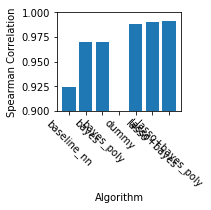

In [28]:
fig, ax = plt.subplots()

ax.bar(range(len(over_time_results)), over_time_results['force_spearman'])

ax.set_xticks(range(len(over_time_results)))
ax.set_xticklabels(list(over_time_results.index), fontsize=10, rotation=-45);

ax.set_ylim(0.9, 1)
ax.set_ylabel('Spearman Correlation')
ax.set_xlabel('Algorithm', fontsize=10)

fig.set_size_inches(2.9, 3)
fig.tight_layout()

fig.savefig('figures/ml_algorithm_error.pdf')
fig.savefig('figures/ml_algorithm_error.png', dpi=320)

Get the best model

In [29]:
best_model = over_time_results.iloc[-1].name
assert best_model == 'lasso+bayes_poly' # Make sure it doesn't change when re-running

Stopping power as a function of training set size. Black line is the known average

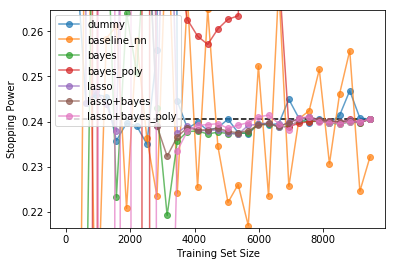

In [30]:
fig, ax = plt.subplots()

ax.plot([0,data['timestep'].max() - data['timestep'].min()], [data['force'].mean(),]*2, 'k--')

for name, my_data in test_results.items():
    ax.plot(my_data['over_time']['training_size'], my_data['over_time']['mean_force'], marker='o', label=name, alpha=0.7)
    
ax.set_ylim(data['force'].mean() * 0.9, data['force'].mean() * 1.1)

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Stopping Power')

*Finding*: Bayesian linear regression with feature selection using LASSO seems to work the best. It has the highest Spearman R, and the MAE is not bad either

## Effect of Fe

## Plot just the best one
Show the model performance

In [31]:
def scale_force(x, exag=3):
    return np.sign(x) * np.power(np.abs(x), 1./exag) 
def unscale_force(x, exag=3):
    return np.sign(x) * np.abs(np.power(x, exag))

In [32]:
best_results = test_results[best_model]
num_tests = len(best_results['over_time']['traj'])

In [33]:
pkl.dump(best_results['model'], open('best_model.pkl', 'wb'))

Plot the convergence of the stopping power

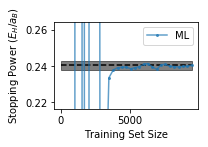

In [34]:
fig, ax = plt.subplots()

ax.plot([0,data['timestep'].max() - data['timestep'].min()], [data['force'].mean(),]*2, 'k--')#, label='Known Value')

ax.fill_between([0, data['timestep'].max() - data['timestep'].min()],
                [data['force'].mean() * 1.01, data['force'].mean() * 1.01],
                [data['force'].mean() * 0.99, data['force'].mean() * 0.99], color='k', alpha=0.5)

ax.plot(best_results['over_time']['training_size'], best_results['over_time']['mean_force'], 
        marker='o', ms=2, alpha=0.7, label='ML')
    
ax.set_ylim(data['force'].mean() * 0.9, data['force'].mean() * 1.1)

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Stopping Power ($E_H/a_B$)')

fig.set_size_inches(3, 2)

fig.tight_layout()
fig.savefig('figures/stopping_power_bayes.pdf')
fig.savefig('figures/stopping_power_bayes.png', dpi=320)

Plot the force error as a function of training set size

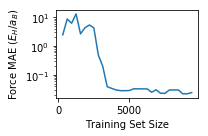

In [35]:
fig, ax = plt.subplots()


mae = [ np.abs(data['force'] - t).mean() for t in best_results['over_time']['traj'] ] 

ax.semilogy(best_results['over_time']['training_size'], mae)
    
    
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Force MAE ($E_H/a_B$)')

fig.set_size_inches(3, 2)

fig.tight_layout()
fig.savefig('figures/mae_training_size.pdf')
fig.savefig('figures/mae_training_size.png', dpi=320)

Plot how well the algorithm forecasts stopping force

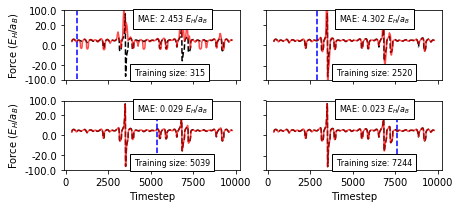

In [36]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


for f,ax in zip([0,int(0.25*num_tests),int(0.5*num_tests),int(0.75*num_tests)],axs.flatten()):
    
    ax.plot(data['timestep'], scale_force(data['force']), 'k--')
    ax.set_ylim(ax.get_ylim()) # Make sure the scales stay appropriate
    
    traj = best_results['over_time']['traj'][f]
    ax.plot(data['timestep'], scale_force(traj), 'r-', alpha=0.7)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(4200, scale_force(30), 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=8,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.text(4000, -4, 'Training size: %d'%best_results['over_time']['training_size'][f],
            fontsize=8,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.plot([best_results['over_time']['step'][f],]*2, ax.get_ylim(), 'b--')

axs[1,0].set_xlabel('Timestep')
axs[1,1].set_xlabel('Timestep')
axs[0,0].set_ylabel('Force ($E_H/a_B$)')
axs[1,0].set_ylabel('Force ($E_H/a_B$)')

# Unscale force
y_ticks = [-100, -20, 0, 20, 100]
axs[0,0].set_yticks(scale_force(y_ticks))
axs[0,0].set_yticklabels(['%.1f'%f for f in y_ticks])
axs[1,0].set_yticks(scale_force(y_ticks))
axs[1,0].set_yticklabels(['%.1f'%f for f in y_ticks])

fig.set_size_inches(6.5,3)
fig.tight_layout()
fig.savefig('figures/ml_over_time.pdf')
fig.savefig('figures/ml_over_time.png', dpi=320)

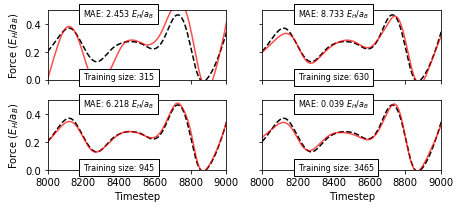

In [37]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


for f,ax in zip([0,1,2,10],axs.flatten()):
    
    ax.plot(data['timestep'], data['force'], 'k--')
    ax.set_ylim(0, 0.5) # Make sure the scales stay appropriate
    ax.set_xlim(8000, 9000)
    
    traj = best_results['over_time']['traj'][f]
    ax.plot(data['timestep'], traj, 'r-', alpha=0.7)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(0.2, 0.9, 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=8,
           bbox=dict(edgecolor='k', facecolor='w'), transform=ax.transAxes)
    
    ax.text(0.2, 0, 'Training size: %d'%best_results['over_time']['training_size'][f],
            fontsize=8, transform=ax.transAxes,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.plot([best_results['over_time']['step'][f],]*2, ax.get_ylim(), 'b--')

axs[1,0].set_xlabel('Timestep')
axs[1,1].set_xlabel('Timestep')
axs[0,0].set_ylabel('Force ($E_H/a_B$)')
axs[1,0].set_ylabel('Force ($E_H/a_B$)')


fig.set_size_inches(6.5,3)
fig.tight_layout()
fig.savefig('figures/ml_over_time-small_forces.pdf')
fig.savefig('figures/ml_over_time-small_forces.png', dpi=320)

## Effect of Feature Selection
Demonstrate the effect of feature selection on the predictions of our models.

In [38]:
force_no_fs = BayesianRidge().fit(data[X_cols], data[y_col]).predict(data[X_cols])

In [39]:
force_with_fs = Pipeline([
    ('lasso_rfe', SelectFromModel(
        LassoLars(normalize=True, max_iter=8, fit_intercept=True, alpha=1e-10))
    ),
    ('model', BayesianRidge())
]).fit(data[X_cols], data[y_col]).predict(data[X_cols])

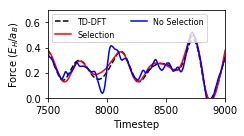

In [40]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['force'], 'k--', label='TD-DFT')
ax.plot(data['timestep'], force_with_fs, 'r', label='Selection')
ax.plot(data['timestep'], force_no_fs, 'b', label='No Selection')

ax.set_xlabel('Timestep')
ax.set_ylabel('Force ($E_H / a_B$)')

ax.legend(fontsize=8, loc=2, ncol=2)

ax.set_xlim(7500, 9000)
ax.set_ylim(0, 0.7)

fig.set_size_inches(3.5, 2)
fig.tight_layout()
fig.savefig('figures/feature_selection.png', dpi=320)
fig.savefig('figures/feature_selection.pdf')

## Compute Stopping Power on Different Path
Read in the files from another Al trajectory. `Al_256_channel` is a simulation at the same velocity as what we have trained this model on, but along a different path in the crystal.

Read in the data

In [41]:
%%time
new_data = []
for file in glob('Al_256_channel/kpg*.out'):
    frame = load_qbox_data(file)
    frame['file'] = file
    new_data.append(frame)
new_data = pd.concat(new_data)
print('Read in %d training points'%len(new_data))

Read in 2000 training points
CPU times: user 1min 7s, sys: 467 ms, total: 1min 8s
Wall time: 1min 8s


In [42]:
new_data.sort_values(['file_id', 'frame_id'], ascending=True, inplace=True)
new_data['timestep'] = list(range(len(new_data)))
new_data.set_index('timestep', inplace=True, drop=False)
new_data['displacement'] = (new_data['position'] - new_data['position'][0]).apply(np.linalg.norm)

Read in the feature calculators

In [43]:
featurizers = pkl.load(open('featurizers.pkl', 'rb'))

In [44]:
%%time
for f in featurizers:
    new_data = f.featurize_dataframe(new_data, 'atoms', n_jobs=None)

CPU times: user 1.75 s, sys: 1.29 s, total: 3.04 s
Wall time: 2min 33s


In [45]:
new_data.drop('atoms', 'columns').to_csv('Al_channel.csv')
new_data.to_pickle('Al_channel.pkl')

Compute the lattice spacing

In [46]:
lat_spacing = new_data['atoms'][0].cell[0,0] / 4

Plot the results

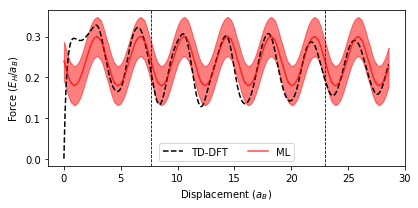

In [47]:
fig, ax = plt.subplots()

# Plot the true result
ax.plot(new_data['displacement'], new_data['force'], 'k--', label='TD-DFT')

# Plot the ML predictions
fmean, fstd = best_results['model'].predict(new_data[X_cols], return_std=True)
ax.fill_between(new_data['displacement'], fmean + fstd, fmean - fstd, color='r', alpha=0.5)
ax.plot(new_data['displacement'], fmean, 'r-', alpha=0.7, label='ML')

# Plot the sample range
ax.set_ylim(ax.get_ylim())

ax.plot([lat_spacing,] * 2, ax.get_ylim(), 'k--', lw=0.8)
ax.plot([lat_spacing * 3,] * 2, ax.get_ylim(), 'k--', lw=0.8)

ax.legend(ncol=2)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H / a_B$)')

fig.set_size_inches(6, 3)
fig.tight_layout()

fig.savefig('figures/stopping_power_Al[001]-trajectory.png', dpi=320)
fig.savefig('figures/stopping_power_Al[001]-trajectory.pdf')

Compute the stopping power with each ML algorithm

In [48]:
new_data_subset = data.query('displacement >= %f and displacement <= %f'%(lat_spacing, lat_spacing * 3))

actual_stopping_power = new_data_subset['force'].mean()
print('Actual Stopping Power:', actual_stopping_power)

names = []
stopping_powers = []
for k,d in test_results.items():
    names.append(k)
    stopping_powers.append(np.mean(d['model'].predict(new_data_subset[X_cols])))
    
errors = [(x - actual_stopping_power) / actual_stopping_power for x in stopping_powers]

Actual Stopping Power: 0.223856302433


In [49]:
pd.DataFrame({'names':names,'S':stopping_powers, 'error':errors}).sort_values('error', ascending=True)

,S,error,names
5,0.228863,0.022366,lasso+bayes
3,0.229533,0.025361,bayes_poly
2,0.230750,0.030794,bayes
4,0.231713,0.035099,lasso
6,0.232412,0.038220,lasso+bayes_poly
1,0.239991,0.072077,baseline_nn
0,0.240551,0.074579,dummy


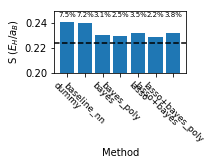

In [50]:
fig, ax = plt.subplots()

# Plot the ML results
ax.bar(list(range(len(names))), stopping_powers)
ax.set_xticks(list(range(len(names))))
ax.set_xticklabels(names, fontsize=9, rotation=-45);

for i,e in enumerate(errors):
    ax.text(i, 0.245, '%.1f%%'%(e* 100), ha='center', fontsize=7)#, bbox={'facecolor': 'w', 'edgecolor': 'w'})

# Plot the actual result
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [actual_stopping_power,] * 2, 'k--')

# Make it pretty
ax.set_ylim(0.2, 0.25)

ax.set_xlabel('Method')
ax.set_ylabel('S ($E_H / a_B$)')

fig.set_size_inches(3, 2.4)
fig.tight_layout()
fig.savefig('figures/stopping_power_Al[001].png', dpi=320)
fig.savefig('figures/stopping_power_Al[001].pdf', dpi=320)
